In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm, uniform
from statsmodels.stats import outliers_influence

In [28]:
#Significance level
ALPHA = 0.11

---

In [29]:
def PlotSimpleRegression(data, variable, ax):

    data = data.copy()
    data = data.sort_values(variable).reset_index(drop=True)

    # Scatterplot of the observations
    sns.scatterplot(
        data = data,
        x=variable,
        y="Life Ladder",
        ax=ax,
        label="Observations"
    )

    # Plot predicted mean
    ax.plot(
        data[variable],
        data["mean"],
        color="k",
        label="Prediction"
    )

    # Plot prediction interval
    ax.fill_between(
        data[variable],
        data["obs_ci_lower"],
        data["obs_ci_upper"],
        color="rebeccapurple",
        alpha=0.5,
        label="Prediction interval"
    )

    # Plot confidence interval
    ax.fill_between(
        data[variable],
        data["mean_ci_lower"],
        data["mean_ci_upper"],
        color="pink",
        alpha=0.5,
        label="Confidence interval"
    )

    ax.legend(frameon=False)
    ax.spines[['right', 'top']].set_visible(False)

    return ax

In [30]:
def PlotCompareYHatY(data, ax):
    ax.scatter(data["Life Ladder"], data["mean"], color="k")

    ax.errorbar(
        data["Life Ladder"],
        data["mean"],
        yerr=data["obs_ci_upper"] - data["mean"],
        fmt="o",
        color="k"
    )

    ax.plot(
        [data["Life Ladder"].min(), data["Life Ladder"].max()]
        , [data["Life Ladder"].min(), data["Life Ladder"].max()]
        , color='r'
        , linestyle='--'
    )

    ax.set_xlabel(r"$Y$")
    ax.set_ylabel(r"$\hat{Y}$")
    ax.spines[['right', 'top']].set_visible(False)

    return ax

---

Reading and preprocessing data

In [31]:
DataWhr2024 = pd.read_csv("DataWhr2024.csv")
UnM49 = pd.read_csv("UnM49.csv", sep=';')

In [32]:
DataWhr2024.loc[DataWhr2024["Country name"].str.startswith("Hong"), "Country name"] = "Hong Kong"
DataWhr2024.loc[DataWhr2024["Country name"].str.startswith("Somaliland"), "Country name"] = "Somaliland"
DataWhr2024.loc[DataWhr2024["Country name"].str.startswith("Taiwan"), "Country name"] = "Taiwan"

In [33]:
UnM49 = UnM49[['Country or Area', 'Sub-region Name', 'Region Name']]
UnM49 = UnM49.rename({'Country or Area':'Country name', 'Sub-region Name':'Subregion', 'Region Name':'Continent'}, axis=1)

In [34]:
UnM49.loc[97, "Country name"] = "Bolivia"
UnM49.loc[33, "Country name"] = "Congo (Brazzaville)"
UnM49.loc[34, "Country name"] = "Congo (Kinshasa)"
UnM49.loc[124, "Country name"] = "Hong Kong"
UnM49.loc[125, "Country name"] = "Macao"
UnM49.loc[126, "Country name"] = "North Korea"
UnM49.loc[145, "Country name"] = "Iran"
UnM49.loc[46, "Country name"] = "Ivory Coast"
UnM49.loc[133, "Country name"] = "Laos"
UnM49.loc[129, "Country name"] = "South Korea"
UnM49.loc[173, "Country name"] = "Moldova"
UnM49.loc[217, "Country name"] = "Netherlands"
UnM49.loc[175, "Country name"] = "Russia"
UnM49.loc[164, "Country name"] = "Syria"
UnM49.loc[26, "Country name"] = "Tanzania"
UnM49.loc[116, "Country name"] = "United States"
UnM49.loc[193, "Country name"] = "United Kingdom"
UnM49.loc[111, "Country name"] = "Venezuela"
UnM49.loc[140, "Country name"] = "Vietnam"

In [35]:
_ = pd.DataFrame(
    {
        "Country name": ["Kosovo", "Somaliland", "Taiwan"],
        "Subregion": ["Southern Europe", "Sub-Saharan Africa", "Eastern Asia"],
        "Continent": ["Europe", "Africa", "Asia"],
    }
)

UnM49 = pd.concat([UnM49, _], axis=0)
UnM49 = UnM49.reset_index(drop=True)

Merging the datasets

In [36]:
# Data
Dat = pd.merge(DataWhr2024, UnM49)

# Data of 2023
Dat2023 = Dat[Dat['year'] == 2023]
Dat2023 = Dat2023.reset_index(drop=True)

In a previous analysis, I found that Afghanistan behaves as a leverage point, while Botswana and Sri Lanka bahave as outliers. Thus, we will not consider these countries in our analyses

In [37]:
Dat2023.loc[[0, 13, 115]]

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0    Afghanistan  2023        1.446                 NaN           0.368   
13      Botswana  2023        3.332               9.673           0.701   
115    Sri Lanka  2023        3.602               9.364           0.790   

     Healthy life expectancy at birth  Freedom to make life choices  \
0                                55.2                         0.228   
13                               55.0                         0.741   
115                              67.4                         0.754   

     Generosity  Perceptions of corruption  Positive affect  Negative affect  \
0           NaN                      0.738            0.261            0.460   
13       -0.264                      0.814            0.657            0.247   
115       0.050                      0.922            0.709            0.353   

              Subregion Continent  
0         Southern Asia      Asia  
13   Sub-Saharan Africa    Africa  
115       Southern Asia      Asia

In [38]:
Dat2023 = Dat2023.drop([0, 13, 115])

More preprocessing

In [39]:
Y = Dat2023["Life Ladder"]

X = Dat2023[[
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption',
    'Positive affect',
    'Negative affect'
]]

X = sm.add_constant(X)

---

# Q1

In [40]:
# Extracting the design matrix and response variable
XGenerosity = X[["const", "Generosity"]].dropna()
YGenerosity = Y[XGenerosity.index]

# Fit the linear regression model
Model1 = sm.OLS(YGenerosity, XGenerosity).fit()
print(Model1.summary())

                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.07861
Date:                Fri, 29 Nov 2024   Prob (F-statistic):              0.780
Time:                        17:57:08   Log-Likelihood:                -187.60
No. Observations:                 127   AIC:                             379.2
Df Residuals:                     125   BIC:                             384.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6752      0.097     58.421      0.0

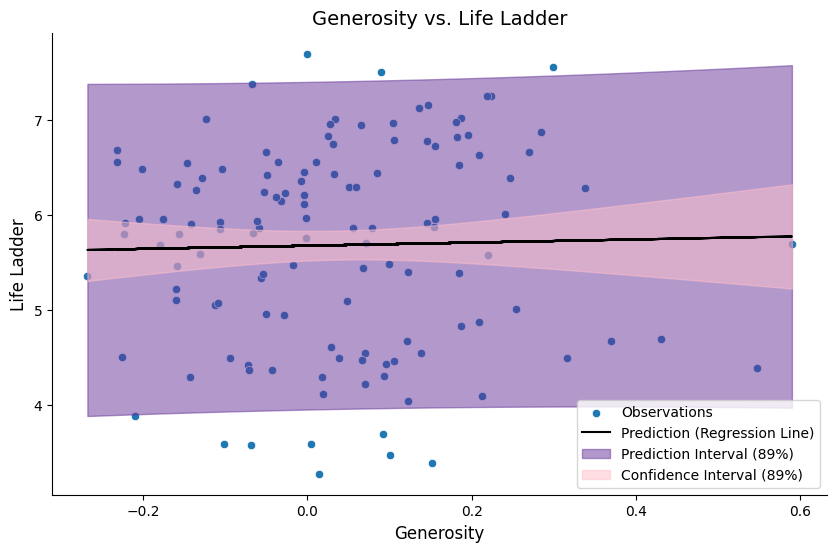

In [41]:
# Ensure that PredictionTable only contains predictions for the same index as XGenerosity
PredictionTable1 = Model1.get_prediction(XGenerosity).summary_frame(alpha=0.11)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatterplot of observations
sns.scatterplot(
    x=XGenerosity["Generosity"], 
    y=YGenerosity, 
    ax=ax, 
    label="Observations"
)

# Plot the predicted mean (regression line)
ax.plot(
    XGenerosity["Generosity"], 
    PredictionTable1["mean"], 
    color="k", 
    label="Prediction (Regression Line)"
)

# Get the min and max of the x-axis for full range
x_min, x_max = XGenerosity["Generosity"].min(), XGenerosity["Generosity"].max()

# Create a smoother x-range for the prediction lines and intervals
x_smooth = np.linspace(x_min, x_max, 300)

# Get the predictions for the smooth x-range
PredictionSmooth = Model1.get_prediction(sm.add_constant(x_smooth)).summary_frame(alpha=0.11)

# Plot prediction intervals across the full x-range
ax.fill_between(
    x_smooth, 
    PredictionSmooth["obs_ci_lower"], 
    PredictionSmooth["obs_ci_upper"], 
    color="rebeccapurple", 
    alpha=0.5, 
    label="Prediction Interval (89%)"
)

# Plot confidence intervals across the full x-range
ax.fill_between(
    x_smooth, 
    PredictionSmooth["mean_ci_lower"], 
    PredictionSmooth["mean_ci_upper"], 
    color="pink", 
    alpha=0.5, 
    label="Confidence Interval (89%)"
)

# Customize the plot
ax.set_title("Generosity vs. Life Ladder", fontsize=14)
ax.set_xlabel("Generosity", fontsize=12)
ax.set_ylabel("Life Ladder", fontsize=12)
ax.legend()
ax.spines[['right', 'top']].set_visible(False)

plt.show()



# Q2

In [42]:
# Create the design matrix XPossitive and the response vector YPossitive
XPossitive = X[['const', 'Positive affect']].dropna()  # Drop missing values from XPossitive
YPossitive = Y.loc[XPossitive.index]  # Align Y with XPossitive, matching indices

# Fit the linear regression model (Model 2)
Model2 = sm.OLS(YPossitive, XPossitive).fit()
print(Model2.summary())

                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     49.54
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           9.33e-11
Time:                        17:57:08   Log-Likelihood:                -177.57
No. Observations:                 135   AIC:                             359.1
Df Residuals:                     133   BIC:                             364.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2346      0.496     

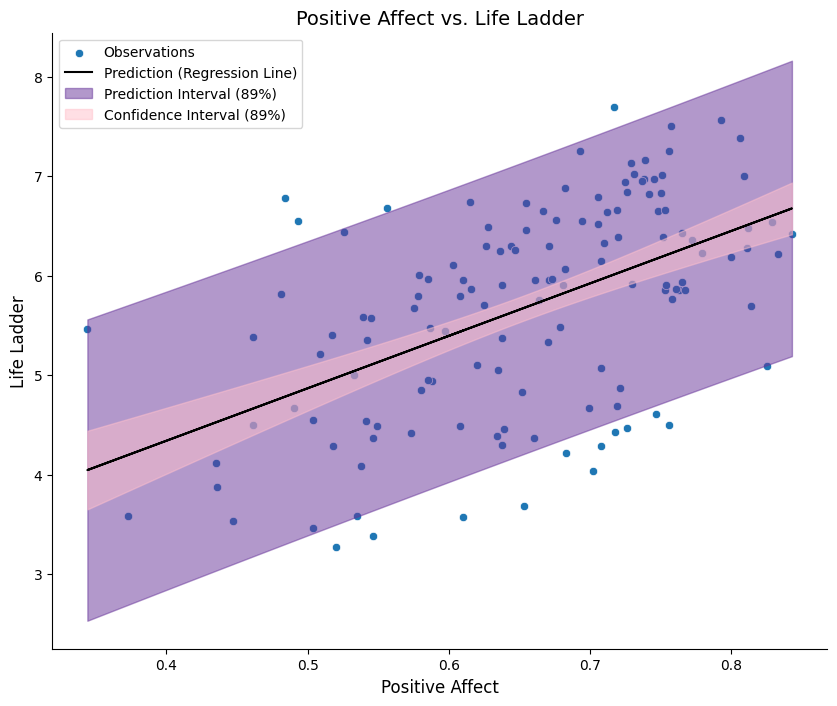

In [43]:
# Ensure that PredictionTable only contains predictions for the same index as XPossitive
PredictionTable2 = Model2.get_prediction(XPossitive).summary_frame(alpha=0.11)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatterplot of observations
sns.scatterplot(
    x=XPossitive["Positive affect"], 
    y=YPossitive, 
    ax=ax, 
    label="Observations"
)

# Plot the predicted mean (regression line)
ax.plot(
    XPossitive["Positive affect"], 
    PredictionTable2["mean"], 
    color="k", 
    label="Prediction (Regression Line)"
)

# Get the min and max of the x-axis for full range
x_min, x_max = XPossitive["Positive affect"].min(), XPossitive["Positive affect"].max()

# Create a smoother x-range for the prediction lines and intervals
x_smooth = np.linspace(x_min, x_max, 300)

# Get the predictions for the smooth x-range
PredictionSmooth = Model2.get_prediction(sm.add_constant(x_smooth)).summary_frame(alpha=0.11)

# Plot prediction intervals across the full x-range
ax.fill_between(
    x_smooth, 
    PredictionSmooth["obs_ci_lower"], 
    PredictionSmooth["obs_ci_upper"], 
    color="rebeccapurple", 
    alpha=0.5, 
    label="Prediction Interval (89%)"
)

# Plot confidence intervals across the full x-range
ax.fill_between(
    x_smooth, 
    PredictionSmooth["mean_ci_lower"], 
    PredictionSmooth["mean_ci_upper"], 
    color="pink", 
    alpha=0.5, 
    label="Confidence Interval (89%)"
)

# Customize the plot
ax.set_title("Positive Affect vs. Life Ladder", fontsize=14)
ax.set_xlabel("Positive Affect", fontsize=12)
ax.set_ylabel("Life Ladder", fontsize=12)
ax.legend()
ax.spines[['right', 'top']].set_visible(False)

plt.show()


# Q3

In [44]:
['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']

['Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect']

In [45]:
# Extract all covariates (independent variables) except the response variable
XAll = X[['const', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 
          'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']].dropna()

# Add a constant column to XAll for the intercept
XAll = sm.add_constant(XAll)

# Ensure YAll is aligned with XAll
YAll = Y.loc[XAll.index]

# Fit the linear regression model (Model 3)
Model3 = sm.OLS(YAll, XAll).fit()

# Display the summary of Model 3
print(Model3.summary())


                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     80.73
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.99e-42
Time:                        17:57:08   Log-Likelihood:                -59.747
No. Observations:                 118   AIC:                             137.5
Df Residuals:                     109   BIC:                             162.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [55]:
PredictionTable3 = Model3.get_prediction(XAll).summary_frame(alpha=0.11)

# Q4

In [47]:
scaler = MinMaxScaler()

X["Healthy life scaled"] = scaler.fit_transform(X[["Healthy life expectancy at birth"]])

X["Log GDP scaled"] = scaler.fit_transform(X[["Log GDP per capita"]])

In [48]:
XAllScaled = X.copy()

XAllScaled = XAllScaled.drop(["Healthy life expectancy at birth", "Log GDP per capita"], axis=1)

XAllScaled = XAllScaled.dropna()

In [49]:
XAll.describe()

const  Log GDP per capita  Social support  \
count  118.0          118.000000      118.000000   
mean     1.0            9.495669        0.790627   
std      0.0            1.149838        0.131170   
min      1.0            7.076000        0.398000   
25%      1.0            8.612500        0.695750   
50%      1.0            9.636000        0.837500   
75%      1.0           10.470250        0.894250   
max      1.0           11.676000        0.979000   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                        118.000000                    118.000000   
mean                          65.237288                      0.796364   
std                            5.492634                      0.113688   
min                           52.200000                      0.452000   
25%                           60.700000                      0.735250   
50%                           66.100000                      0.817500   
75%                           69.650000                      0.877000   
max                           74.600000                      0.965000   

       Generosity  Perceptions of corruption  Positive affect  Negative affect  
count  118.000000                 118.000000       118.000000       118.000000  
mean     0.034373                   0.722347         0.654653         0.293610  
std      0.162590                   0.173567         0.106431         0.088618  
min     -0.268000                   0.184000         0.344000         0.114000  
25%     -0.072500                   0.663250         0.578250         0.229250  
50%      0.022000                   0.767500         0.667000         0.283000  
75%      0.134250                   0.844500         0.738750         0.357500  
max      0.590000                   0.948000         0.843000         0.516000

In [50]:
XAllScaled.describe()

const  Social support  Freedom to make life choices  Generosity  \
count  118.0      118.000000                    118.000000  118.000000   
mean     1.0        0.790627                      0.796364    0.034373   
std      0.0        0.131170                      0.113688    0.162590   
min      1.0        0.398000                      0.452000   -0.268000   
25%      1.0        0.695750                      0.735250   -0.072500   
50%      1.0        0.837500                      0.817500    0.022000   
75%      1.0        0.894250                      0.877000    0.134250   
max      1.0        0.979000                      0.965000    0.590000   

       Perceptions of corruption  Positive affect  Negative affect  \
count                 118.000000       118.000000       118.000000   
mean                    0.722347         0.654653         0.293610   
std                     0.173567         0.106431         0.088618   
min                     0.184000         0.344000         0.114000   
25%                     0.663250         0.578250         0.229250   
50%                     0.767500         0.667000         0.283000   
75%                     0.844500         0.738750         0.357500   
max                     0.948000         0.843000         0.516000   

       Healthy life scaled  Log GDP scaled  
count           118.000000      118.000000  
mean              0.582022        0.526015  
std               0.245207        0.249965  
min               0.000000        0.000000  
25%               0.379464        0.334022  
50%               0.620536        0.556522  
75%               0.779018        0.737880  
max               1.000000        1.000000

In [51]:
from numpy.linalg import cond

condition_XAll = cond(XAll.values)
condition_XAllScaled = cond(XAllScaled.values)

condition_XAll.round(4), condition_XAllScaled.round(4)

(np.float64(1508.9221), np.float64(43.9715))

# Q5

In [52]:
XScaleFewVariables = X.drop(["Healthy life expectancy at birth", "Log GDP per capita"], axis=1)

XScaleFewVariables = XScaleFewVariables.drop(["const", "Healthy life scaled", "Generosity", "Negative affect"], axis=1).dropna()

XScaleFewVariables = XScaleFewVariables - XScaleFewVariables.mean()

XScaleFewVariables = sm.add_constant(XScaleFewVariables)

YScaleFewVariables = Y[XScaleFewVariables.index]

Model4 = sm.OLS(YScaleFewVariables, XScaleFewVariables).fit()

print(Model4.summary())


                            OLS Regression Results                            
Dep. Variable:            Life Ladder   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     119.1
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.26e-43
Time:                        17:57:08   Log-Likelihood:                -66.306
No. Observations:                 119   AIC:                             144.6
Df Residuals:                     113   BIC:                             161.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [53]:
PredictionTable4 = Model4.get_prediction(XScaleFewVariables).summary_frame(alpha=0.11)

# Q6

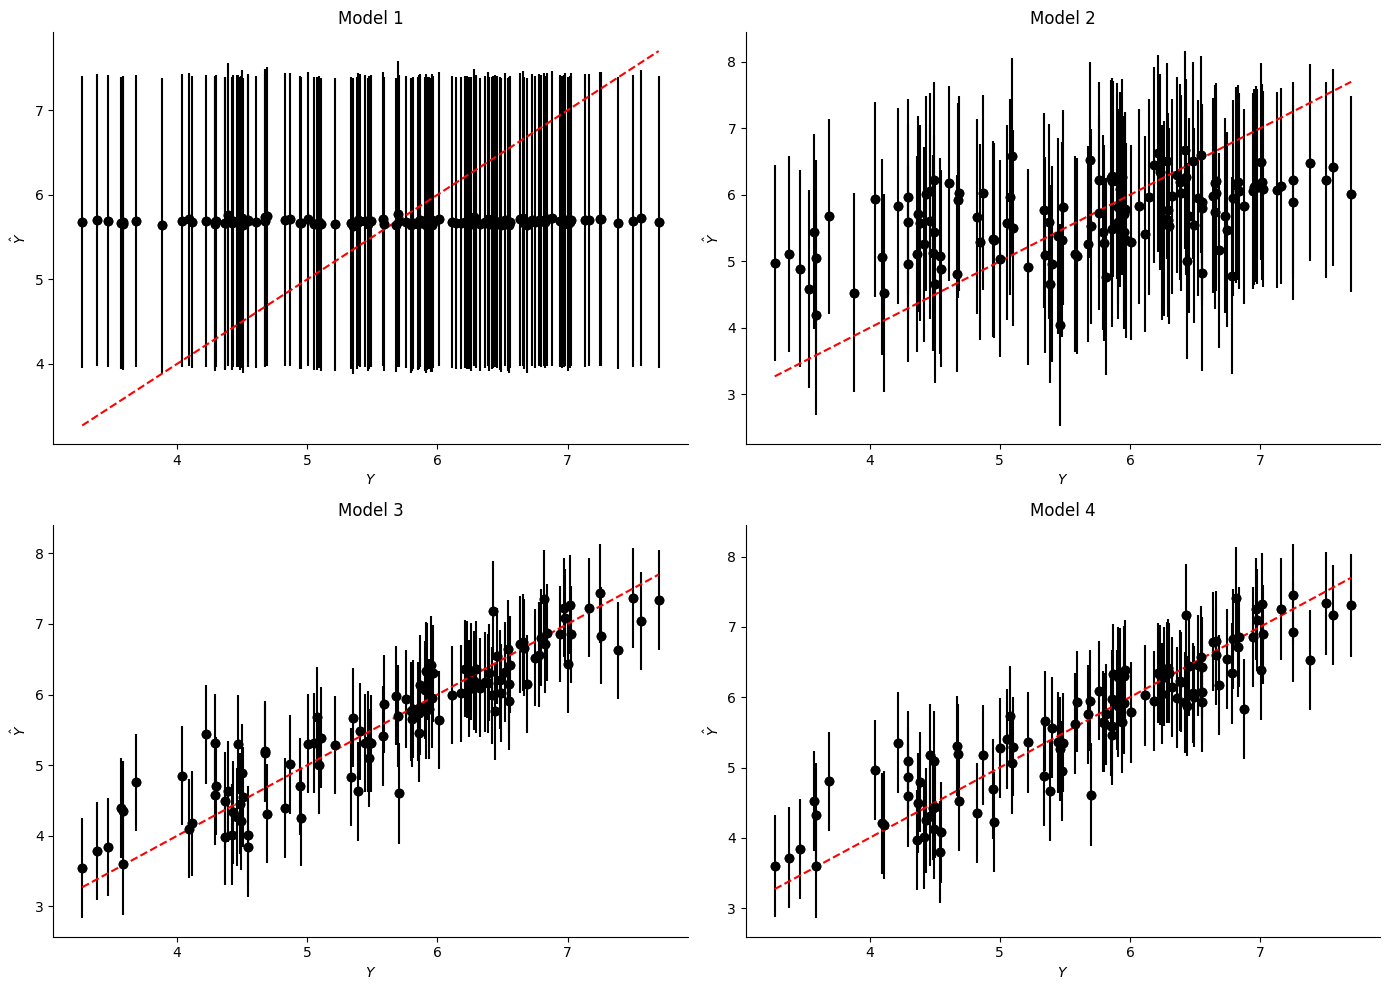

In [54]:
import matplotlib.pyplot as plt

# Assuming PredictionTables and Y variables for each model are already calculated:
# Replace these with actual data (e.g., YModel1, PredictionTableModel1)
models = [
    ("Model 1", YGenerosity, PredictionTable1),
    ("Model 2", YPossitive, PredictionTable2),
    ("Model 3", YAll, PredictionTable3),
    ("Model 4", YScaleFewVariables, PredictionTable4),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, (model_name, Y, PredictionTable) in zip(axes, models):
    # Scatter plot of actual vs predicted values
    ax.scatter(Y, PredictionTable["mean"], color="k")
    
    # Add error bars for prediction interval
    yerr = PredictionTable["obs_ci_upper"] - PredictionTable["mean"]
    ax.errorbar(Y, PredictionTable["mean"], yerr=yerr, fmt="o", color="k")
    
    # Add identity line
    ax.plot(
        [Y.min(), Y.max()],
        [Y.min(), Y.max()],
        color="r",
        linestyle="--",
    )
    
    # Set labels and title
    ax.set_xlabel(r"$Y$")
    ax.set_ylabel(r"$\hat{Y}$")
    ax.set_title(model_name)
    ax.spines[["right", "top"]].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()
